<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_9/9_3_TermDocumentSentiment_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Part 2


---

in Part 2 we are going to use another `lexicon-based` method using nltk's SentimentIntensityAnalyzer() and TextBlob()

- SentimentIntensityAnalyzer() is a sentiment analysis tool in the Natural Language Toolkit (NLTK). It calculates the sentiment of the **text** not the term by assigning scores to the terms  based on their polarity (positive, negative or neutral) and intensity so unlike part 1, this will generate a score(acutally 4 scores) for each review. 

- TextBlob() It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.






In [ ]:
import warnings
warnings.filterwarnings('ignore')

# standard libries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import string
import re

# text libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud


# Download our Parser, stopwords, and sentiment mapping


---



In [ ]:
# download nltk datasets
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data


---

Today's data comes from Yelp! we have a bunch of reviews of coffee shops and resturants in Austin TX. Let's dive in and take a look! 

In [ ]:
yelp = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/ratings_and_sentiments.csv", encoding="ISO-8859-1")
yelp.head(5)


,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,seating_sent,price_sent,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,0.0,0.0,0,0.0,1.0,3,0,0.0,0.0,0.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,0.0,0.0,0,0.0,0.0,0,2,0.0,0.0,0.0
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,3.0,0.0,0,0.0,0.0,-1,2,0.0,0.0,0.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,-1.0,-1.0,0,0.0,0.0,0,0,0.0,0.0,0.0
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,0.0,0.0,3,0.0,0.0,0,0,0.0,0.0,0.0


## Extract the Date and convert it


---

Each review contains the date as the first character string (word) for example "11/25/2016 1 check-in Love love loved the vibe" we want to extract that date into a new column called review_date and cast it to a date data type. 

> `.str.split() is used to split each string in a colun into a *list* of substrings based on a specified separator (sep = " ")`


In [ ]:
yelp["review_date"] = yelp["review_text"].str.split().str[0]
yelp["review_date"] = pd.to_datetime(yelp["review_date"] )
yelp.head(5)

,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,...,price_sent,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent,review_date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,...,0.0,0,0.0,1.0,3,0,0.0,0.0,0.0,2016-11-25
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,...,0.0,0,0.0,0.0,0,2,0.0,0.0,0.0,2016-12-02
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,...,0.0,0,0.0,0.0,-1,2,0.0,0.0,0.0,2016-11-30
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,...,-1.0,0,0.0,0.0,0,0,0.0,0.0,0.0,2016-11-25
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,...,0.0,3,0.0,0.0,0,0,0.0,0.0,0.0,2016-12-03


# Clean up Reviews



---

we know that the first word in the review is the date, sometimes there is a count and number of check-in or check-ins ex: "1 check-in" or "2 check-ins" are embeded in the review. lets remove these! 



In [ ]:
# create a mask to check if 'check-in' or 'check-ins' is in the string
mask = yelp['review_text'].str.contains('check-in|check-ins')

# replace null values in 'review_text' with '2023-01-01 no-review'
yelp['review_text'] = yelp['review_text'].fillna('2023-01-01 no-review')

# chain the methods to remove the first three words if the mask is True, otherwise remove just the first word
yelp['review_text_clean'] = (yelp['review_text']
                             .apply(lambda x: ' '.join(x.split()[3:]) if (mask.any() and x is not None) else x.split()[1] if x is not None else None))

yelp.head(5)

,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,...,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent,review_date,review_text_clean
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,...,0,0.0,1.0,3,0,0.0,0.0,0.0,2016-11-25,Love love loved the vibe! Every corner of the ...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,...,0,0.0,0.0,0,2,0.0,0.0,0.0,2016-12-02,"Date Night: Austin, vibe in Austin BEAUTIFUL!!..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,...,0,0.0,0.0,-1,2,0.0,0.0,0.0,2016-11-30,Listed in food seating I loved the eclectic an...
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,...,0,0.0,0.0,0,0,0.0,0.0,0.0,2016-11-25,vibe! Good drinks Nice seating However... Just...
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,...,3,0.0,0.0,0,0,0.0,0.0,0.0,2016-12-03,They are location within the Northcross mall s...


# Using SentimentIntensityAnalyzer()


---

SentimentIntensityAnalyzer() is a sentiment analysis tool in the Natural Language Toolkit (NLTK). It uses a lexicon-based approach to calculate the sentiment of the text by assigning scores to the words based on their polarity (positive, negative or neutral) and intensity.

The SentimentIntensityAnalyzer() returns a dictionary containing four sentiment scores: positive, negative, neutral, and compound. The positive, negative and neutral scores represent the proportion of the text that falls into each sentiment category. The compound score is a normalized score between -1 and 1 that represents the overall sentiment of the text. A compound score of 1 represents very positive sentiment, -1 represents very negative sentiment, and 0 represents neutral sentiment.



In [ ]:
# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to get the sentiment scores for each review text
def get_sentiment_scores(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores

# Apply the get_sentiment_scores() function to each review text in the 'review_text_clean' column
yelp['sentiment_scores'] = yelp['review_text_clean'].apply(get_sentiment_scores)

# Extract the compound sentiment score from the sentiment_scores dictionary and store it in a new column
yelp['sentiment_compound_score'] = yelp['sentiment_scores'].apply(lambda x: x['compound'])
yelp['sentiment_pos_score'] = yelp['sentiment_scores'].apply(lambda x: x['pos'])
yelp['sentiment_neg_score'] = yelp['sentiment_scores'].apply(lambda x: x['neg'])
yelp['sentiment_neu_score'] = yelp['sentiment_scores'].apply(lambda x: x['neu'])
# Print the updated Yelp dataframe
yelp.head()

,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,...,hours_sent,internet_sent,local_sent,review_date,review_text_clean,sentiment_scores,sentiment_compound_score,sentiment_pos_score,sentiment_neg_score,sentiment_neu_score
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the vib...,5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,...,0.0,0.0,0.0,2016-11-25,Love love loved the vibe! Every corner of the ...,"{'neg': 0.0, 'neu': 0.821, 'pos': 0.179, 'comp...",0.9283,0.179,0.000,0.821
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe ...",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,...,0.0,0.0,0.0,2016-12-02,"Date Night: Austin, vibe in Austin BEAUTIFUL!!...","{'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'comp...",0.9187,0.283,0.000,0.717
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in food seating ...,4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,...,0.0,0.0,0.0,2016-11-30,Listed in food seating I loved the eclectic an...,"{'neg': 0.004, 'neu': 0.815, 'pos': 0.181, 'co...",0.9936,0.181,0.004,0.815
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice s...,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,...,0.0,0.0,0.0,2016-11-25,vibe! Good drinks Nice seating However... Just...,"{'neg': 0.142, 'neu': 0.704, 'pos': 0.154, 'co...",0.2244,0.154,0.142,0.704
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are location within...,4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,...,0.0,0.0,0.0,2016-12-03,They are location within the Northcross mall s...,"{'neg': 0.016, 'neu': 0.833, 'pos': 0.15, 'com...",0.9393,0.150,0.016,0.833


# Use the Compound Score


---



In [ ]:
# Group the Yelp dataframe by 'coffee_shop_name', calculate the mean and count of the 'sentiment_compound_score' column, rename the columns, and reset the index
restaurant_summary = (yelp
                      .groupby('coffee_shop_name')['sentiment_compound_score']
                      .agg(['mean', 'count'])
                      .rename(columns={'mean': 'mean_sentiment_score', 'count': 'review_count'})
                      .reset_index()
                      .sort_values("review_count",ascending=False)
)
restaurant_summary.head()

,coffee_shop_name,mean_sentiment_score,review_count
19,Epoch Coffee,0.730242,400
28,Halcyon,0.755016,300
68,The Factory - Cafe With a Soul,0.748916,244
9,Caffe Medici,0.686193,243
31,Houndstooth Coffee,0.749758,200


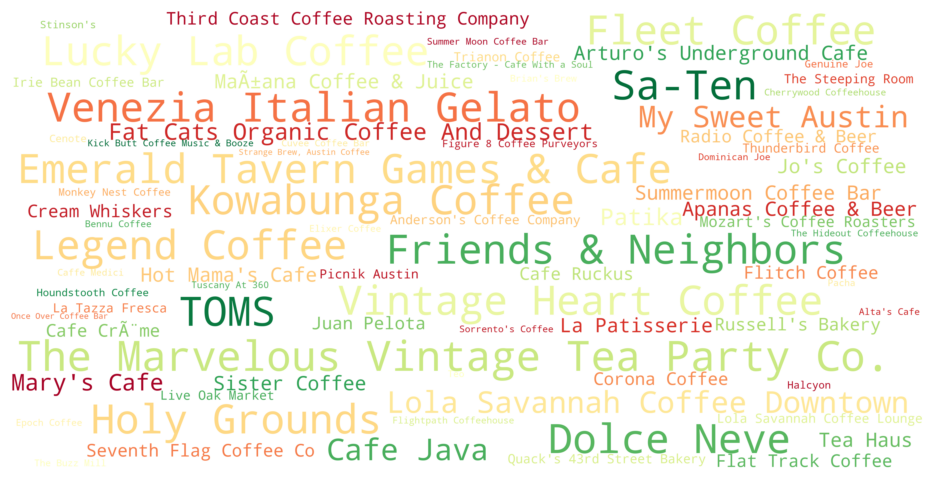

In [ ]:

# Create a dictionary of term frequency counts and sentiment scores
freq_dict = dict(zip(restaurant_summary["coffee_shop_name"], restaurant_summary['review_count']))
sentiment_dict = dict(zip(restaurant_summary["coffee_shop_name"], restaurant_summary['mean_sentiment_score']))

# Generate the wordcloud with the coffee shop names as the text, the mean sentiment score as the color, and the review count as the size
wordcloud = WordCloud(background_color='white', colormap="RdYlGn", prefer_horizontal=1, width=800, height=400, max_font_size=100, scale=5).generate_from_frequencies(frequencies=sentiment_dict)

# Display the wordcloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

coolwarm


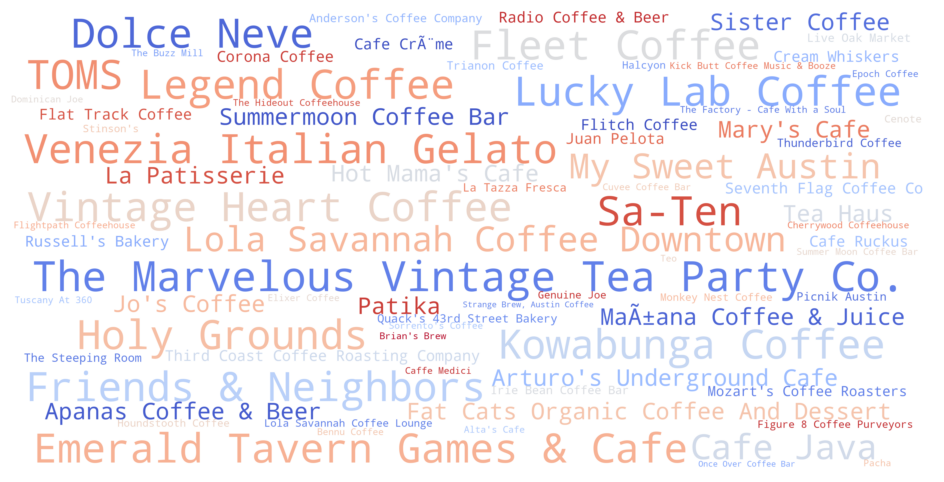

Blues


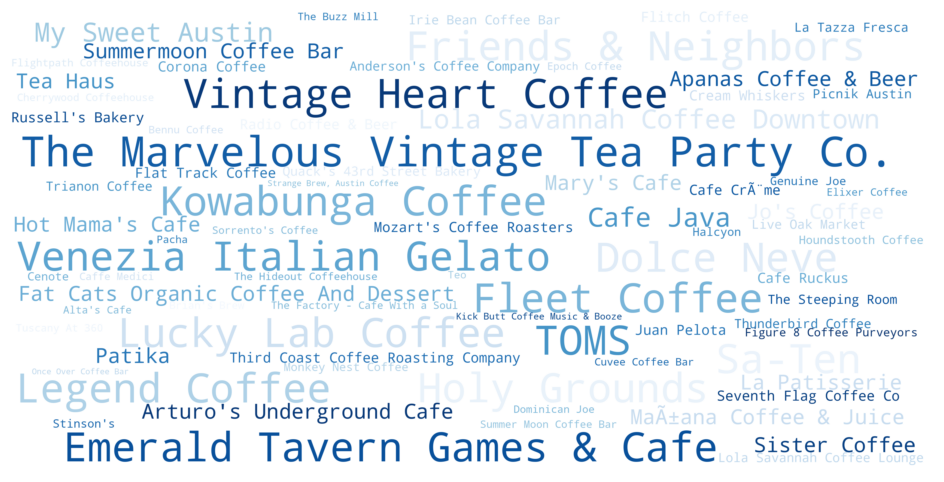

YlOrRd


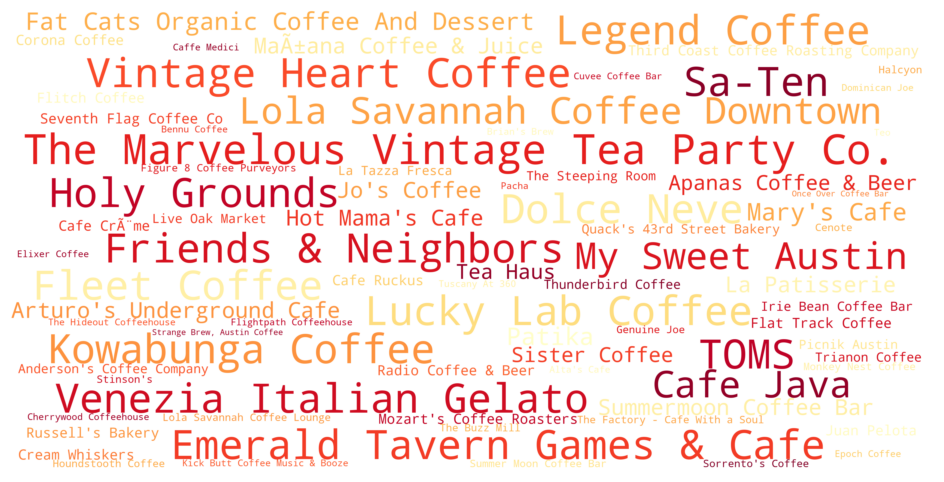

GnBu


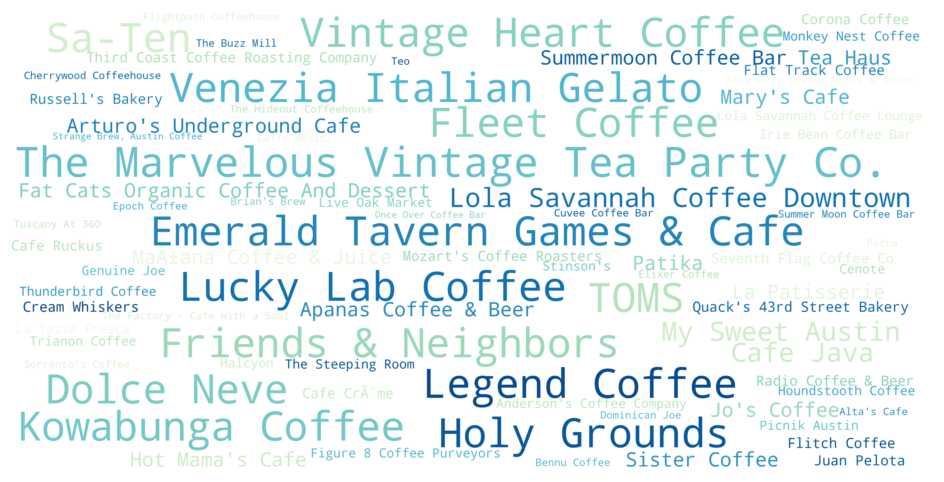

In [ ]:
list_o_colormaps = ["coolwarm","Blues","YlOrRd","GnBu"]

for colormap in list_o_colormaps:
  print(colormap)
  wordcloud = WordCloud(background_color='white', 
                      colormap=colormap, 
                      prefer_horizontal=1, width=800, height=400, max_font_size=100, scale=5).generate_from_frequencies(frequencies=sentiment_dict)

  # Display the wordcloud
  plt.figure(figsize=(12, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

# Using TextBlob()


---



In [ ]:
from textblob import TextBlob


In [ ]:
# Define a function to calculate sentiment scores using TextBlob
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply the sentiment function to the 'review_text_clean' column
yelp['tb_sentiment_score'] = yelp['review_text_clean'].apply(calculate_sentiment)


In [ ]:
# Group the Yelp dataframe by 'coffee_shop_name', calculate the mean and count of the 'sentiment_compound_score' column, rename the columns, and reset the index
restaurant_summary = (yelp
                      .groupby('coffee_shop_name')['tb_sentiment_score']
                      .agg(['mean', 'count'])
                      .rename(columns={'mean': 'mean_sentiment_score', 'count': 'review_count'})
                      .reset_index()
                      .sort_values("review_count",ascending=False)
)
restaurant_summary.head()

,coffee_shop_name,mean_sentiment_score,review_count
19,Epoch Coffee,0.269880,400
28,Halcyon,0.265221,300
68,The Factory - Cafe With a Soul,0.338095,244
9,Caffe Medici,0.273504,243
31,Houndstooth Coffee,0.291895,200


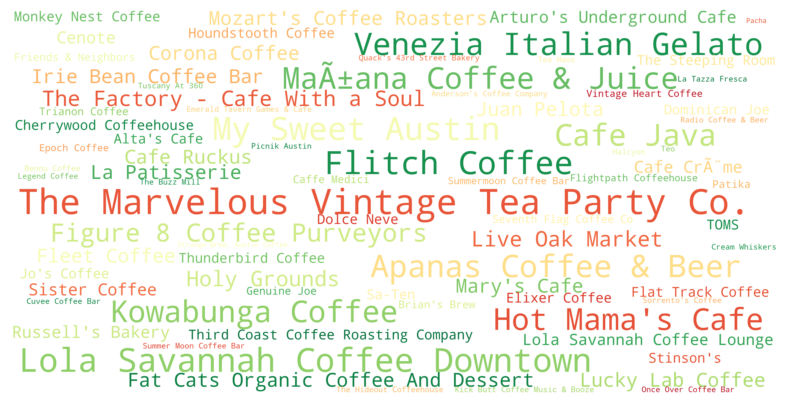

In [ ]:
# Create a dictionary of term frequency counts and sentiment scores
freq_dict = dict(zip(restaurant_summary["coffee_shop_name"], restaurant_summary['review_count']))
sentiment_dict = dict(zip(restaurant_summary["coffee_shop_name"], restaurant_summary['mean_sentiment_score']))

# Generate the wordcloud with the coffee shop names as the text, the mean sentiment score as the color, and the review count as the size
wordcloud = WordCloud(background_color='white', colormap="RdYlGn", prefer_horizontal=1, width=800, height=400, max_font_size=100, scale=5).generate_from_frequencies(frequencies=sentiment_dict)

# Display the wordcloud
plt.figure(figsize=(10, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()